In [124]:
import pandas as pd
import sqlalchemy
import seaborn as sns
import matplotlib.pyplot as plt
import pub_ready_plots
from pub_ready_plots import get_mpl_rcParams
rc_params, fig_width_in, fig_height_in = pub_ready_plots.get_mpl_rcParams(
    width_frac=1,  # between 0 and 1
    height_frac=0.2,  # between 0 and 1
    layout="jmlr"  # or "iclr", "neurips", "poster-portrait", "poster-landscape"
)
rc_params['figure.constrained_layout.use'] = True
plt.rcParams.update(rc_params)



RESULTS_DIR = "aki_evals"

db_name = [f"{RESULTS_DIR}/seg_evals.sqlite",
           f"{RESULTS_DIR}/bin_evals.sqlite"]




In [125]:

def model_name(exp):
    if 'inicenodelite_' in exp:
        return 'eICE-NODE'
    if 'gruodebayes' in exp:
        return 'GRU-ODE-Bayes'
    if 'ingru' in exp:
        return 'GRU'
    if 'inkoopman' in exp:
        return 'Koopman'
    if 'inicenodeliteicnn' in exp:
        return 'ODE-ICNN'
    assert False
    
def loss_name(exp):
    if 'mse' in exp:
        return 'mse'
    if 'bce' in exp:
        return 'bce'
    assert False

def predictor_name(exp):    
    if exp.startswith('mlp'):
        return 'mlp'
    if exp.startswith('monotonic'):
        return f'monotonic'
    assert False

def batch_size(exp):
    if 'B2' in exp:
        return 2
    else:
        return 64
    assert False

def icenode_dyn(exp):
    if 'inicenodelite_gru_' in exp:
        return 'gru'
    if 'inicenodelite' in exp:
        return 'mlp'
    else:
        return 'NA'
        


def sql2dataframe(db):
    engine = sqlalchemy.create_engine("sqlite:///%s" % db, execution_options={"sqlite_raw_colnames": True},
                                     connect_args={'timeout': 5})
    
    df = {name: pd.read_sql_table(name, engine) for name in 
          ('evaluation_runs', 'evaluation_status', 'experiments', 'metrics', 'results')}
    df['results']
    
    metrics = df['metrics'].rename(columns={'name': 'metric', 'id': 'metric_id'})
    eval_runs = df['evaluation_runs'].rename(columns={'id': 'evaluation_id'})
    experiments = df['experiments'].rename(columns={'name': 'experiment', 'id': 'experiment_id'})
    eval_status = df['evaluation_status'].rename(columns={'id': 'status_id', 'name': 'status'})
    
    res = pd.merge(df['results'], metrics, left_on='metric_id', right_on='metric_id', how='left')
    res = pd.merge(res, eval_runs, left_on='evaluation_id', right_on='evaluation_id', how='left')
    res = pd.merge(res, experiments, left_on='experiment_id', right_on='experiment_id', how='left')
    res = pd.merge(res, eval_status, left_on='status_id', right_on='status_id', how='left')
    res['step'] = res.snapshot.str.extract('(\d+)').astype(int)

    res = res.sort_values(['experiment_id', 'step'])
    res['last_max'] = float('nan')
    res['last_min'] = float('nan')
    res['is_max'] = False
    res['is_min'] = False
    res['max'] = float('nan')
    res['min'] = float('nan')
    
    for exp, exp_df in res.groupby('experiment_id'):
        for metric, metric_df in exp_df.groupby('metric'):
            index = metric_df.index
            res.loc[index, 'last_max'] = metric_df['value'].cummax()
            res.loc[index, 'last_min'] = metric_df['value'].cummin()
            res.loc[index, 'is_max'] = metric_df['value'] == res.loc[index, 'last_max']
            res.loc[index, 'is_min'] = metric_df['value'] == res.loc[index, 'last_min']
            res.loc[index, 'max'] = metric_df['value'].max()
            res.loc[index, 'min'] = metric_df['value'].min()
            
    
    res = res[[col for col in res.columns if 'id' not in col]]

    res['model'] = res.experiment.map(model_name)
    res['loss'] = res.experiment.map(loss_name)
    res['predictor'] = res.experiment.map(predictor_name)
    res['batch_size'] = res.experiment.map(batch_size)
    res['icenode_dyn'] = res.experiment.map(icenode_dyn)
    
    return res


def experiment_mincost_snapshots(dataframe, 
                                 cost_metrics = ['ObsPredictionLossMetric.mse', 'LeadPredictionLossMetric.mse']):
    def experiment_step_min_cost(experiment_df):
        return pd.Series({'best_step': experiment_df.loc[experiment_df['value'].idxmin(), 'step']})
        
    results2 = dataframe[dataframe.metric.isin(cost_metrics)]
    results2 = results2[['experiment', 'step', 'value']].groupby(['experiment', 'step']).sum().reset_index()
    results2 = results2.groupby('experiment').apply(experiment_step_min_cost).reset_index()
    return results2.set_index('experiment')['best_step'].to_dict()




In [126]:
results = pd.concat([sql2dataframe(db) for db in db_name])

In [129]:
best_experiment_snapshot = experiment_mincost_snapshots(results)

In [130]:
results

,value,metric,created_at,updated_at,snapshot,experiment,status,step,last_max,last_min,is_max,is_min,max,min,model,loss,predictor,batch_size,icenode_dyn
0,7.243400e+04,LeadingAKIPredictionAccuracy.n_timestamps_nega...,2024-08-07 07:02:24.982616,2024-08-08 08:44:56.853237,step7260.eqx,monotonic_bce_inicenodelite_gru_g0,FINISHED,7260,7.243400e+04,7.243400e+04,True,True,7.243400e+04,7.243400e+04,eICE-NODE,bce,monotonic,64,gru
1,NaN,LeadingAKIPredictionAccuracy.n_timestamps_unknown,2024-08-07 07:02:24.982616,2024-08-08 08:44:56.853237,step7260.eqx,monotonic_bce_inicenodelite_gru_g0,FINISHED,7260,NaN,NaN,False,False,NaN,NaN,eICE-NODE,bce,monotonic,64,gru
2,8.929600e+04,LeadingAKIPredictionAccuracy.n_timestamps_firs...,2024-08-07 07:02:24.982616,2024-08-08 08:44:56.853237,step7260.eqx,monotonic_bce_inicenodelite_gru_g0,FINISHED,7260,8.929600e+04,8.929600e+04,True,True,8.929600e+04,8.929600e+04,eICE-NODE,bce,monotonic,64,gru
3,5.330500e+04,LeadingAKIPredictionAccuracy.n_timestamps_late...,2024-08-07 07:02:24.982616,2024-08-08 08:44:56.853237,step7260.eqx,monotonic_bce_inicenodelite_gru_g0,FINISHED,7260,5.330500e+04,5.330500e+04,True,True,5.330500e+04,5.330500e+04,eICE-NODE,bce,monotonic,64,gru
4,NaN,LeadingAKIPredictionAccuracy.n_timestamps_reco...,2024-08-07 07:02:24.982616,2024-08-08 08:44:56.853237,step7260.eqx,monotonic_bce_inicenodelite_gru_g0,FINISHED,7260,NaN,NaN,False,False,NaN,NaN,eICE-NODE,bce,monotonic,64,gru
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1411,1.031961e-01,ObsPredictionLossMetric.mae,2024-08-08 22:30:42.483903,2024-08-09 07:50:35.948343,step16240.eqx,monotonic_mse_ingru_g0,FINISHED,16240,1.042551e-01,1.028673e-01,False,False,1.042551e-01,1.028673e-01,GRU,mse,monotonic,64,NA
1412,3.524395e-02,ObsPredictionLossMetric.mse,2024-08-08 22:30:42.483903,2024-08-09 07:50:35.948343,step16240.eqx,monotonic_mse_ingru_g0,FINISHED,16240,3.629415e-02,3.475800e-02,False,False,3.629415e-02,3.475800e-02,GRU,mse,monotonic,64,NA
1413,-inf,ObsPredictionLossMetric.r2,2024-08-08 22:30:42.483903,2024-08-09 07:50:35.948343,step16240.eqx,monotonic_mse_ingru_g0,FINISHED,16240,-inf,-inf,True,True,-inf,-inf,GRU,mse,monotonic,64,NA
1414,1.793092e-01,ObsPredictionLossMetric.rms,2024-08-08 22:30:42.483903,2024-08-09 07:50:35.948343,step16240.eqx,monotonic_mse_ingru_g0,FINISHED,16240,1.810275e-01,1.781423e-01,False,False,1.810275e-01,1.781423e-01,GRU,mse,monotonic,64,NA


In [131]:
experiments = pd.DataFrame(results.experiment.unique(), columns=['label'])
experiments['model'] = experiments.label.map(model_name)
experiments['loss'] = experiments.label.map(loss_name)
experiments['predictor'] = experiments.label.map(predictor_name)
experiments['batch_size'] = experiments.label.map(batch_size)
experiments['icenode_dyn'] =  experiments.label.map(icenode_dyn)
experiments = experiments.set_index(['model', 'icenode_dyn', 'loss', 'predictor', 'batch_size']).sort_index()
experiments.index.is_unique

True

In [132]:
# results.metric.unique()


In [133]:
results.set_index(['model', 'icenode_dyn', 'loss', 'predictor', 'batch_size']).sort_index().index.is_unique

False

In [136]:


def make_selection(results_dataframe, selectors):
    y = results_dataframe
    for k, vs in selectors.items():
        y = y[y[k].isin(vs)]
    return y


## AUC bar plots (eICE-NODE, GRUODEBayes, GRU)

In [141]:
auc_results_df = make_selection(results, selectors = {
    'metric': [
        # 'PerColumnObsPredictionLoss.mean(mse)',
        # 'LeadPredictionLossMetric.mse',
        # 'ObsPredictionLossMetric.mse'
        # 'LeadingAKIPredictionAccuracy.AUC_first_pre_emergence_6.0-48.0',
        'LeadingAKIPredictionAccuracy.AUC_pre_emergence_6.0-48.0',
           # 'LeadingAKIPredictionAccuracy.AUC_first_pre_emergence_12.0-48.0',
        'LeadingAKIPredictionAccuracy.AUC_pre_emergence_12.0-48.0', 
            # 'LeadingAKIPredictionAccuracy.AUC_first_pre_emergence_24.0-48.0',
        'LeadingAKIPredictionAccuracy.AUC_pre_emergence_24.0-48.0',
        # 'LeadingAKIPredictionAccuracy.AUC_first_pre_emergence_36.0-48.0',
        'LeadingAKIPredictionAccuracy.AUC_pre_emergence_36.0-48.0'
    ],
    # 'model': [
    #     # 'eICE-NODE', 
    #     # 'GRU-ODE-Bayes', 
    #     'GRU'
    # ],
    'predictor': [
        'mlp',
        'monotonic'
    ],
    'icenode_dyn': [
        'mlp', 
        'gru', 
        'NA'
    ],
    'loss': [
        'mse', 
        'bce'
    ],
    'batch_size':
    [
        64,
        2
    ],
    'experiment': 
    [
        "monotonic_bce_inicenodelite_gru_g0", 
        "monotonic_bce_gruodebayes_g0", 
        "mlp_mse_ingru_g0"
    ]
})

auc_results_df['best_snapshot'] = auc_results_df.experiment.map(best_experiment_snapshot)
auc_top_results_df = auc_results_df[auc_results_df.step == auc_results_df.best_snapshot]
auc_top_results_df = auc_top_results_df[['experiment', 'metric', 'value']]
# auc_top_results_df = auc_results_df.groupby(['experiment', 'metric'])[['value']].max().reset_index()
auc_top_results_df.experiment = auc_top_results_df.experiment.map({
    "monotonic_bce_inicenodelite_gru_g0": "eICE-NODE", 
    "monotonic_bce_gruodebayes_g0": "GRU-ODE-Bayes",
    "mlp_mse_ingru_g0": "GRU"
})

window_map = {
    'LeadingAKIPredictionAccuracy.AUC_pre_emergence_6.0-48.0': r"$6h \to 48h$",
    'LeadingAKIPredictionAccuracy.AUC_pre_emergence_12.0-48.0': r"$12h \to 48h$", 
    'LeadingAKIPredictionAccuracy.AUC_pre_emergence_24.0-48.0': r"$24h \to 48h$",
    'LeadingAKIPredictionAccuracy.AUC_pre_emergence_36.0-48.0' : r"$36h \to 48h$"
}

auc_top_results_df.metric = auc_top_results_df.metric.map(window_map)

auc_top_results_df = auc_top_results_df.rename(columns={"metric": "Time Window",
                                                       "experiment": "Model",
                                                       "value": "AUC"})
# auc_results_df.experiment.unique()

In [142]:
auc_top_results_df

,Model,Time Window,AUC
17,eICE-NODE,$6h \to 48h$,0.661970
23,eICE-NODE,$12h \to 48h$,0.654410
29,eICE-NODE,$24h \to 48h$,0.647666
35,eICE-NODE,$36h \to 48h$,0.633922
961,GRU-ODE-Bayes,$6h \to 48h$,0.683397
967,GRU-ODE-Bayes,$12h \to 48h$,0.672974
973,GRU-ODE-Bayes,$24h \to 48h$,0.665782
979,GRU-ODE-Bayes,$36h \to 48h$,0.646686
27865,GRU,$6h \to 48h$,0.755913
27871,GRU,$12h \to 48h$,0.755913


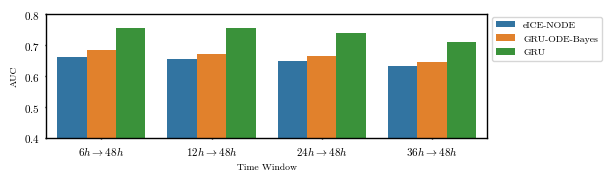

In [143]:


ax = sns.barplot(auc_top_results_df, x="Time Window", y="AUC", hue="Model", order=list(window_map.values()))
_ = ax.legend(bbox_to_anchor=(1, 1.02), loc='upper left')
ax.set_ylim(0.4, 0.8)

ax.get_figure().set_size_inches(fig_width_in, fig_height_in)
ax.get_figure().savefig(f"{RESULTS_DIR}/top_auc_windows.pdf")

## Cost Tables: $L_f$: Forecasting MSE, $L_\text{aki}$: Early Prediction Cost, $L_f + L_\text{aki}$ 

In [154]:
cost_results_df = make_selection(results, selectors = {
    'metric': [
        'LeadPredictionLossMetric.mse',
        'ObsPredictionLossMetric.mse'
    ],
    # 'model': [
        # 'eICE-NODE', 
        # 'GRU-ODE-Bayes', 
    #     'GRU'
    # ],
    'predictor': [
        'mlp',
        'monotonic'
    ],
    'icenode_dyn': [
        'mlp', 
        'gru', 
        'NA'
    ],
    'loss': [
        'mse', 
        'bce'
    ],
    'batch_size':
    [
        64,
        2
    ],
    'experiment': 
    [
        "monotonic_bce_inicenodelite_gru_g0", 
        "monotonic_bce_gruodebayes_g0", 
        "mlp_mse_ingru_g0"
    ]
})

cost_results_df['best_snapshot'] = cost_results_df.experiment.map(best_experiment_snapshot)
cost_top_results_df = cost_results_df[cost_results_df.step == cost_results_df.best_snapshot]
cost_top_results_df = cost_top_results_df[['metric', 'value', 'model']]

window_map = {
    'LeadPredictionLossMetric.mse': r"$L_q$",
    'ObsPredictionLossMetric.mse': r"$L_z$",
}
cost_top_results_df.metric = cost_top_results_df.metric.map(window_map)

cost_top_results_df = cost_top_results_df.pivot(index="model", columns="metric", values="value")
cost_top_results_df[r"$L_z + L_q$"] = cost_top_results_df[r"$L_q$"] + cost_top_results_df[r"$L_z$"]
cost_top_results_df

metric,$L_q$,$L_z$,$L_z + L_q$
model,,,
GRU,0.147424,0.035038,0.182462
GRU-ODE-Bayes,0.218311,0.054221,0.272532
eICE-NODE,0.239360,0.033283,0.272643


## Table: Inference Time, #Dyn_Parameters, #Timestamps (binning vs free).

In [179]:
def experiment_snapshot_total_time(dataframe):
    def total_time(snapshot_df):
        return  pd.Series({
            'total_time': snapshot_df.iloc[0].updated_at - snapshot_df.iloc[0].created_at})
    return dataframe.groupby(['experiment', 'step']).apply(total_time)


def experiment_snapshot_evaluation_time(dataframe):
    eval_time_metrics = [m for m in dataframe.metric.unique() if m.endswith('.eval_time')]
    times = dataframe[dataframe.metric.isin(eval_time_metrics)].set_index(['experiment', 'step'])[['metric', 'value']]
    times.loc[:, 'value'] = times.loc[:, 'value'].map(lambda seconds: pd.Timedelta(seconds=seconds))
    times = times.pivot(columns='metric', values='value')
    times['total_time'] = times.sum(axis=1)
    return times

In [184]:
for_time_df = make_selection(results, selectors = {
    'predictor': [
        'mlp',
        'monotonic'
    ],
    'icenode_dyn': [
        'mlp', 
        'gru', 
        'NA'
    ],
    'loss': [
        'mse', 
        'bce'
    ],
    'batch_size':
    [
        64,
        2
    ],
    'experiment': 
    [
        "monotonic_bce_inicenodelite_gru_g0", 
        "monotonic_bce_gruodebayes_g0", 
        "mlp_mse_ingru_g0"
    ]
})

exp_map = for_time_df.set_index("experiment")["model"].to_dict()
# Inference + Evaluation Time
experiments_total_time = experiment_snapshot_total_time(for_time_df)
# Time per evaluation module
experiments_evaluation_time = experiment_snapshot_evaluation_time(for_time_df)
# Inference times
experiments_total_time['evaluation_time'] = experiments_evaluation_time.total_time
experiments_total_time['inference_time'] = experiments_total_time.total_time - experiments_evaluation_time.total_time

In [203]:
experiments_total_time_median = experiments_total_time.groupby(level=0)[experiments_total_time.columns].median()
experiments_total_time_median.index = experiments_total_time_median.index.map(exp_map)
experiments_total_time_median.index.name = "Model"
experiments_total_time_median = experiments_total_time_median.apply(lambda x: x.dt.total_seconds() / 3600)
experiments_total_time_median = experiments_total_time_median[['inference_time']]
experiments_total_time_median.columns = ['Inference Time (h)']
experiments_total_time_median.style.format(precision=1)

,Inference Time (h)
Model,
GRU,9.1
GRU-ODE-Bayes,32.9
eICE-NODE,33.9


## ICE-NODE Ablation.